# Field of view optimisation for airborne sensor performance

This notebook implements a variation of the performance model developed by T M Goss *et al.*. *Field of View Selection for Optimal Airborne Imaging Sensor Performance*, Proc SPIE, Vol 9071, doi:10.1117/12.2049911, 2014(, \url{http://proceedings.spiedigitallibrary.org/proceeding.aspx?articleid=1878628}).  We also use the material developed in *Electro-Optical System Analysis and Design: A Radiometry Perspective*, CJ Willers, SPIE, DOI: 10.1117/3.1001964, 2013 (\url{http://spie.org/Publications/Book/2021423}).  The first reference is identified as [G] and the second reference is identified as [W] in the text below.  If no reference is given, [G] is implied.

The present form of the model can account for atmospheric transmittance and path radiance effects, but the present calculation does not include this. The results presented here therefore only apply to short-range observations.

The model is a much simplified version of reality, and could benefit from improvement in many areas, but even in its present form it is already quite useful. In particular the absence of atmospheric modelling is somewhat restrictive, but can easily be overcome. The model author [G] stated the following (reasonable) constraints:

The model is useful to compare similar imaging sensors. The optimization and comparison process
assumes the imaging sensor is well designed and that the following design aspects are taken care of:

1.  The optical design is such that the exit pupil is placed close to the front lens/window and limited vignetting is permitted thereby ensuring that the real optical aperture diameter equal to the theoretical optical aperture.
1. The optics is always optimally focused.
1. The optical design is such that no significant stray light or glare issues exist.
1. The electronic design is such that no significant additional noise sources exist i.e. other than those identified in this paper.

Similarly the performance of any thermal imaging sensor may be optimized within the constraints of the application
using the model, for comparing  thermal imagers. The optimization and comparison process assumes the thermal imaging sensor is well designed and that the following design aspects are taken care of:

1.  The same assumptions regarding the optical and electronic designs above apply except that vignetting is not permitted.
1. The cold stop efficiency is 100% (achieved by imaging the entrance pupil onto the cold stop).
1. A cold filter ensures no out-of-band radiation reaches the detector pixels.
1. The detector temperature regulation is sufficient and no low frequency noise components compromise the thermal imaging sensor’s performance i.e. only white noise is present.



# Prepare environment

This report is created from an IPython notebook which includes all the code to calculate the results.  

In [1]:
# to prepare the Python environment
import numpy as np
import scipy as sp
import pandas as pd
import os.path
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import integrate
from scipy import signal
from scipy import ndimage
import matplotlib.pyplot as plt
import scipy.constants as const
import pickle

import collections

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

import pyradi.ryplot as ryplot
import pyradi.ryplanck as ryplanck
import pyradi.ryfiles as ryfiles
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

import matplotlib as mpl
mpl.rc("savefig", dpi=300)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'
pim = ryplot.ProcessImage()
pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 150)

In [2]:
# to define the sensor parameters used in this analysis

foclen = 1. # normalised focal length in m
inttime = 0.01 # default integration time

# read the excel spreadsheet containing the sensor data and extract the example data
dfS = pd.read_excel('data/FOV-optimisation-parameters.xlsx', 'Sheet1', index_col=None, na_values=['NA'])
dfS.set_index(keys='Sensor',inplace=True)

# get a list of the spectral band definitions from the data set
dfS.loc['Spectral band Mid'] = (dfS.loc['Spectral band Lo'] + dfS.loc['Spectral band Hi']) / 2.
specBands = dfS.loc['Band'].unique()
wlcs = {}
for specBand in specBands:
    wlcs[specBand] = dfS.loc['Spectral band Mid'][dfS.loc['Band']==specBand][0]

# get list of MTF labels and matching masks
mtfLabels = dfS.loc['MTF label'].unique()
dOptics = {}
for mtfLabel in mtfLabels:
    dOptics[mtfLabel] = dfS.loc['Pupil mask'][dfS.loc['MTF label']==mtfLabel][0]

# get max spatial frequency for sensor aperture and wavelength
dfS.loc['SpatFreqMax cy/m'] = dfS.loc['Optics diameter'] / dfS.loc['Spectral band Mid']
dfS = dfS.append(pd.DataFrame(index=['SpatFreq cy/m']))
for colname in dfS.columns.values:
    dfS.loc['SpatFreq cy/m'][colname] = np.linspace(0, dfS.loc['SpatFreqMax cy/m'][colname], 100)

print(specBands)
print(wlcs)
print(mtfLabels)
print(dOptics)
print(dfS.drop('SpatFreq cy/m', axis=0))


[u'Visible' u'MWIR']
{u'Visible': 5.399999999999999e-07, u'MWIR': 4.350000000000001e-06}
[u'Central 0.25' u'No obscuration']
{u'No obscuration': u'data/mask00.png', u'Central 0.25': u'data/mask01.png'}
                          MWIR Sensor A    MWIR Sensor B     Vis Sensor A     Vis Sensor B
Sensor                                                                                    
Band                               MWIR             MWIR          Visible          Visible
Sensor Type                         MCT              MCT             CMOS             CMOS
Spectral band Lo                3.7e-06          3.7e-06          4.8e-07          4.8e-07
Spectral band Hi                  5e-06            5e-06            6e-07            6e-07
Pixels H                            640              640             1280             1280
Pixels V                            512              512              720              720
Pixel size                      1.5e-05          1.5e-05          5.5e

## Signal model

The [G] model calculates the signal and noise components from primary sensor parameters, allowing for the sensor MTF.  The model describes the noise equivalent temperature or noise equivalent reflectance in terms of spatial frequency and then solves for the noise equivalent terms in terms of spatial frequency.

The sensor's perceived signal to noise ratio when imaging a square wave bar target
in the presence of sensor noise is given by

\begin{equation}
\textrm{SNR} = \frac{\textrm{CTF}(\xi) \cdot [n_{\textrm{signal}} - n_{\textrm{background}}] }{n_{\textrm{noise}}}
\end{equation}
where 
$\textrm{SNR}$ is the signal to noise ratio, 
$\textrm{CTF}(\xi)$ is the sensor's contrast transfer function, 
$\xi$ is spatial frequency,
$n_{\textrm{signal}}$ is the signal electron count in the detector, 
$n_{\textrm{background}}$ is the background electron count in the detector, and 
$n_{\textrm{noise}}$ is the sensorn noise at the sensor output.  The signal as defined here is the signal in one pixel. 


Using a variation of the camera equation (Equation 9.56 in [W]) the electron count in the detector from a source contrast radiance $\Delta L$ is given by the flux on the detector multiplied by the quantum efficiency and the integration time:

\begin{equation}
\Delta n_{\textrm{det}\; \lambda}
=
\frac{\pi \eta_{\lambda} t_{\textrm{int}} K_C K_N(\alpha) A_d \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}\left[L_{\textrm{signal}\lambda}- L_{\textrm{background}\lambda}\right] \cos^4\alpha}{4F_\#^2(1+|m|)^2},
\end{equation}
where
$\eta_{\lambda}$ is the detector spectral quantum efficiency,
$t_{\textrm{int}}$ is the detector integration time, 
$K_C$ an efficiency factor accounting for a central obscuration (if present), 
$K_N(\alpha)$  is the vignetting losses (if present),
$A_d$ is the area of the detector, 
$\tau_{o\lambda}$ is the optics transmittance, 
$\tau_{f\lambda}$ is the spectral filter transmittance, 
$\tau_{a\lambda}$ is the atmospheric transmittance, 
$L_{\textrm{signal}\lambda}$ is the signal source radiance,
$L_{\textrm{background}\lambda}$ is the background source radiance,
$\cos^4\alpha$ is the cosine-to-the-fourth losses,
$\alpha$ is the field angle,
$F_\#$ is the sensor f-number, and
$m$ is the magnification.


At inifinte conjugates $m$=0, with on-axis viewing $\alpha$=0, with no vignetting $K_N(\alpha)$=0, the camera equation for target contrast becomes

\begin{equation}
\Delta n_{\textrm{det}}
=
\left(\frac{\pi t_{\textrm{int}} K_C  A_d }{4F_\#^2}\right)\cdot
\int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}\left[L_{\textrm{signal}\lambda}- L_{\textrm{background}\lambda}\right] d\lambda
\end{equation}



Rejoining [G] we define the noise equivalent quanta as the the contrast quantum signal where the signal to noise is equal to one.  In keeping with [W] notation noise equivalent quanta is written as NEQ. Then 

\begin{equation}
\textrm{NEQ} = \frac{n_{\textrm{noise}}}{\textrm{CTF}(\xi)} = 
\left(\frac{\pi t_{\textrm{int}} K_C  A_d }{4F_\#^2}\right)\cdot
\int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}\left[L_{\textrm{signal}\lambda}- L_{\textrm{background}\lambda}\right] d\lambda
\end{equation}



From [G]: If we assume the square wave response of the sensor is band-limited and that for the higher spatial
frequencies only the fundamental of the square wave has sufficient response, then the amplitude conversion from the square wave $\textrm{CTF}$ to the sinusoid modulation transfer function, $\textrm{MTF}$, is a factor $4/\pi$

\begin{equation}
\textrm{CTF}(\xi) \approx \frac{4}{\pi}\textrm{MTF}(\xi)
\end{equation}


After manipulation we arrive at Equation 7 in [G]:

\begin{equation}
\pi\int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}\textrm{LEQ}_\lambda d\lambda
=
\frac{\pi F_\#^2 n_{\textrm{noise}}}{ t_{\textrm{int}} K_C  A_d\textrm{MTF}(\xi)} 
\end{equation}
with units of q/(s$\cdot$m$^2$), and 
where 
$\textrm{LEQ}_\lambda = L_{\textrm{signal}\lambda}- L_{\textrm{background}\lambda}$ is understood to be the contrast radiance between two pixels that provides a signal to noise ratio of one.


**Thermal sources:** Expanding on Section 9.5.4 in [W] that for small temperature differences, the noise equivalent temperature difference for a thermal source can be approximated by

\begin{equation}
\frac{\textrm{LEQ}}{\textrm{NETD}} = \frac{dL}{dT} = \int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}
\left(
\frac{L_\lambda(T_{\textrm{background}})}{dT}
\right)
d\lambda
\end{equation}



Hence for thermal sources a form similar to Equation 9 in [G] is derived

\begin{equation}
 \textrm{NETD}
=
\frac{ F_\#^2 n_{\textrm{noise}}}{ t_{\textrm{int}} K_C  A_d\textrm{MTF}(\xi)\left[ \int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}
\left(
\frac{L_\lambda(T_{\textrm{background}})}{dT}
\right)
d\lambda\right]} 
\end{equation}


**Reflective sources:** Similarly to the thermal source derivation,  for target reflection differences, the noise equivalent reflection difference for a reflective source can be approximated by

\begin{equation}
\frac{\textrm{LEQ}}{ \textrm{NE}\rho} = \frac{dL}{d\rho} = \int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}
L_{\textrm{source}\lambda}
d\lambda
\end{equation}



Hence for reflective sources we derive an equation similar to Equation 7 in [G]:

\begin{equation}
 \textrm{NE}\rho
=
\frac{ F_\#^2 n_{\textrm{noise}}}{ t_{\textrm{int}} K_C  A_d\textrm{MTF}(\xi) \int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}
L_{\textrm{source}\lambda}
d\lambda} 
\end{equation}


## Noise model

There are several noise sources in imaging sensors, as well documented in the open literature.  A convenient summary in the form of the Konnik model is given here: \url{http://arxiv.org/pdf/1412.4031.pdf} and its Python implementation is given in notebook 09b of this series, available here: \url{http://nbviewer.jupyter.org/github/NelisW/ComputationalRadiometry/blob/master/09b-StaringArrayDetectors.ipynb}

The [G] model includes photon noise and fixed patter non-uniformity noise.  The model can readily be extended to account for other noise sources as well.

Photon noise for a flux signal is given by the square root of the signal photon count.  The signal photon count comprises photons from the scene (target and background temperatures assumed to the more or less the same), photons from inside the sensor such as hot optics (other sources ignored for now), and atmosperic path radiance.   On the assumption that the atmospheric path temperature is close to the scene temperature the path radiance plus attenuated scene radiance would be more or less equal to the unattenuated scene radiance, i.e., $L_\textrm{path} + \tau_\textrm{path} L_\textrm{scene}\approx L_\textrm{scene}$.

The scene-radiance photon count is given by
\begin{equation}
n_{\textrm{scene}}
=
\left(\frac{\pi t_{\textrm{int}} K_C  A_d }{4F_\#^2}\right)\cdot
\int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}
L_{\textrm{background}\lambda}
d\lambda
\end{equation}

The hot-optics photon count is given by
\begin{equation}
n_{\textrm{optics}}
=
\left(\frac{\pi t_{\textrm{int}} K_C  A_d }{4F_\#^2}\right)\cdot
\int_0^\infty \eta_{\lambda} (1-\tau_{o\lambda})\tau_{f\lambda} \tau_{a\lambda}
L_{\textrm{optics}\lambda}
d\lambda
\end{equation}



The total photon flux is
\begin{equation}
n_{\textrm{photons}} = n_{\textrm{scene}} + n_{\textrm{optics}}
\end{equation}

The photon noise is then 

\begin{equation}
n_{\textrm{photnoise}} =\sqrt{n_{\textrm{photons}}} =  \sqrt{n_{\textrm{scene}} + n_{\textrm{optics}}}
\end{equation}

From [G] and [Konnik]

1. The non-uniformity noise vir visual CCD and CMOS sensors is a gaussian noise with standard deviation $n_{\textrm{NU}}$ given by  $U=n_{\textrm{NU}}/n_{\textrm{photons}}$, with $U$ less than or equal to  1% for CCD and 5% for CMOS sensors.

2. The non-uniformity noise for infrared sensors has the form 
$n_{\textrm{NU}}\leq \left(\sqrt{n_{\textrm{photons}}}\right)^{-1}$


The total noise  is then given by

\begin{equation}
n_{\textrm{noise}} = \sqrt{n_{\textrm{photnoise}}^2+ n_{\textrm{NU}}^2}
\end{equation}

For visual band sensors (corresponding to Equation 10 in [G])
\begin{equation}
n_{\textrm{noise}} = \sqrt{n_{\textrm{photnoise}}^2+ (U n_{\textrm{photons}})^2}
\end{equation}


For infrared sensors
\begin{equation}
n_{\textrm{noise}} 
= \sqrt{n_{\textrm{photnoise}}^2+ \left(\sqrt{n_{\textrm{photons}}}\right)^{-2}}
= \sqrt{n_{\textrm{photons}}+ n_{\textrm{photons}}^{-1}}
\end{equation}



## MTF components

### Detector MTF

The detector MTF is modelled as a `sinc` function

\begin{equation}
MTF_{\textrm{det}} = \textrm{sinc}\left( \pi\xi \alpha\right)= \textrm{sinc}\left(  \frac{\pi\xi\beta}{f}\right)
\end{equation}

where 
$\xi$ is spatial frequency in cy/rad, and 
$\alpha$ is the detector angular size in rad,
$\beta$ is the detector size in meters,
$f$ is the focal length in meters.  

The dimensional analysis of the argument is not immediately evident: one detector subtends half a cycle and this must be accounted for in the dimensional analysis:

\begin{equation}
\left[\frac{\textrm{rad}}{1}\right]
\left[\frac{\textrm{cy}}{\textrm{rad}}\right]
\left[\frac{\textrm{rad}}{\textrm{pix}}\right]
\left[\frac{\textrm{pix}}{\textrm{cy}}\right]
\rightarrow 
\left[\frac{\textrm{rad}}{1}\right]
\left[\frac{\textrm{cy}}{\textrm{rad}}\right]
\left[\frac{\textrm{m}}{\textrm{pix}}\right]
\left[\frac{\textrm{pix}}{\textrm{cy}}\right]
\left[\frac{\textrm{1}}{\textrm{m}}\right]
\rightarrow 
\textrm{rad}
\end{equation}

Note: the numpy sinc function already includes a $\pi$ in the function code, don't add it in your code!!!

In [3]:
# to calculate detector MTF
def MTFdetector(freq, pixsize, foclen):
    # freq in cy/rad
    # pixsize in m
    # foclen in m
    return np.sinc(freq * pixsize  / foclen)

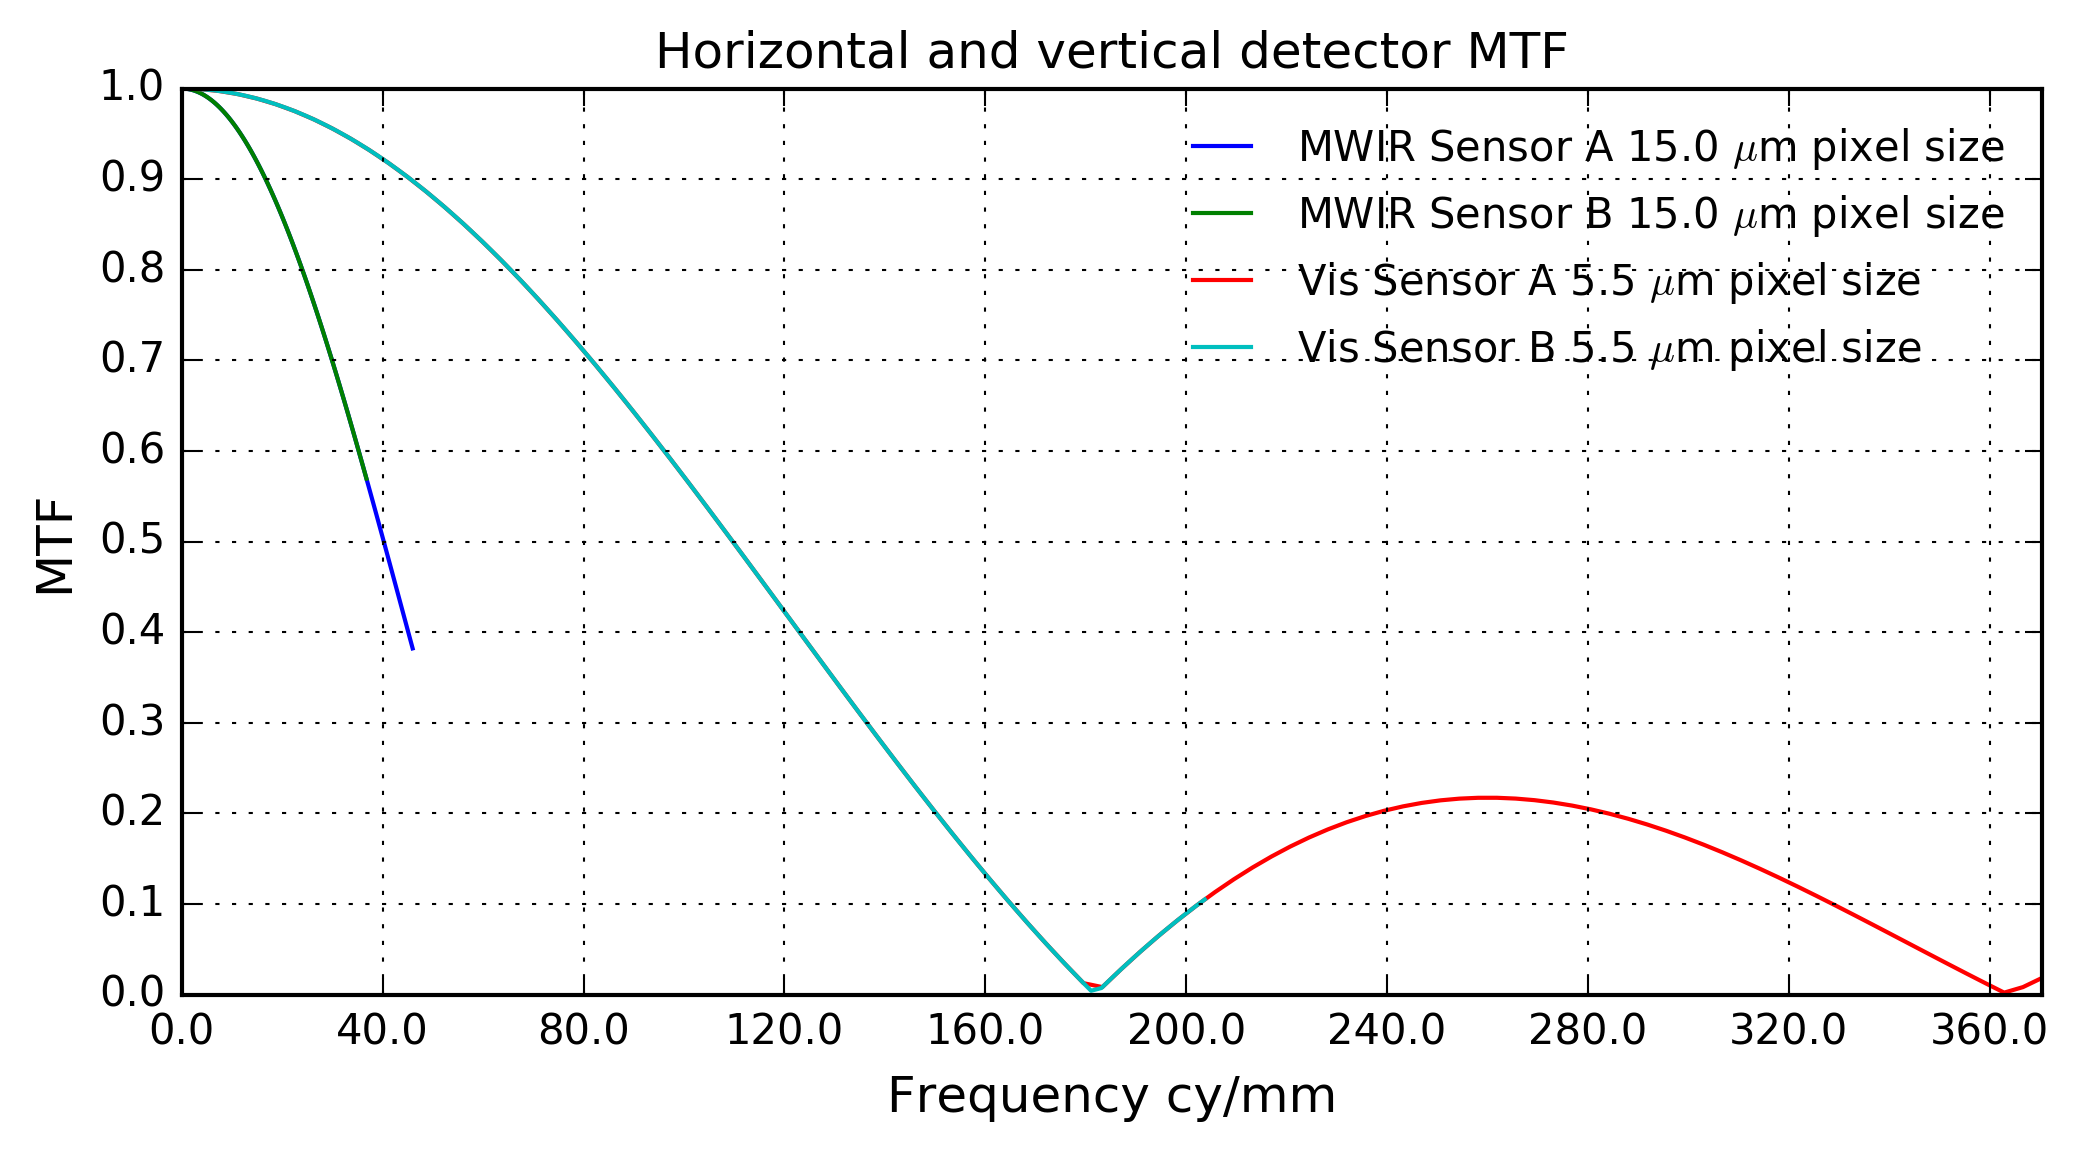

In [4]:
# to plot detector MTF as function of detector pixel size
p = ryplot.Plotter (1 ,1 ,1 , figsize =(8 ,4) )
if 'MTF detector' not in dfS.index.values:
    dfS = dfS.append(pd.DataFrame(index=['MTF detector']))
ffreqmax = np.max(dfS.loc['SpatFreqMax cy/m'])
for colname in dfS.columns.values:
    ffreq = dfS.loc['SpatFreq cy/m'][colname]
    pixsize = dfS.loc['Pixel size'][colname]
    dfS.loc['MTF detector'][colname] = MTFdetector(ffreq,pixsize,foclen)
    p.plot(1, ffreq/1000., np.abs(dfS.loc['MTF detector'][colname]),
           r'Horizontal and vertical detector MTF','Frequency cy/mm','MTF',
           label=[r'{} {} $\mu$m pixel size'.format(colname, pixsize*1e6)],
           pltaxis =[0,ffreqmax/1000.,-0,1]);

### Optics aberration MTF

From [G], the optics aberration can be modelled by the generic function

\begin{equation}
MTF_\textrm{opt}
= 
\exp
\left[
-2\left(
\frac{\pi \sigma_\textrm{d}\xi}{\xi_0}
\right)^2\right]
= 
\exp
\left[
-2\left(
\frac{\pi \sigma_\textrm{d}\xi\lambda}{D}
\right)^2\right]
\end{equation}
where
$\sigma_\textrm{d}$ is the spot size factor,
$\xi$ is spatial frequency in cy/m,
$\xi_0$ is cutof or critical spatial frequency in cy/m,
$\lambda$ is the mean wavelength, and
$D$ is the aperture diameter in m.



 The units of the square root of the argument are 
 
\begin{equation}
\left[\frac{\textrm{rad}}{\textrm{1}}\right]
\left[\frac{\textrm{m}}{\textrm{m}}\right]
\left[\frac{\textrm{cy}}{\textrm{rad}}\right]
\left[\frac{\textrm{rad}}{\textrm{cy}}\right]
\rightarrow 
\textrm{rad}
\rightarrow 
\left[\frac{\textrm{m}}{\textrm{m}}\right]
\rightarrow 
\textrm{1}
\end{equation}

and

\begin{equation}
\left[\frac{\textrm{rad}}{\textrm{1}}\right]
\left[\frac{\textrm{m}}{\textrm{m}}\right]
\left[\frac{\textrm{cy}}{\textrm{rad}}\right]
\left[\frac{\textrm{m}_\lambda}{\textrm{1}}\right]
\left[\frac{\textrm{1}}{\textrm{m_d}}\right]
\rightarrow 
\left[\frac{\textrm{m}}{\textrm{m}}\right]
\rightarrow 
\textrm{1}
\end{equation}


In [5]:
# to calculate aberration MTF
def MTFaberation(freq, sratio, freqo):
    # freq in cy/rad
    # spot size factor
    # cutof freq in cy/mrad
    return np.exp(-2. * (np.pi * sratio * freq / freqo) ** 2)

In [6]:
# to calculate the MTF of diffraction through a circular aperture
def MTFcirc(freq):
    f = np.abs(freq / np.max(freq))
    return 2. * ( np.arccos(f) - f * np.sqrt(1-f**2)) / np.pi

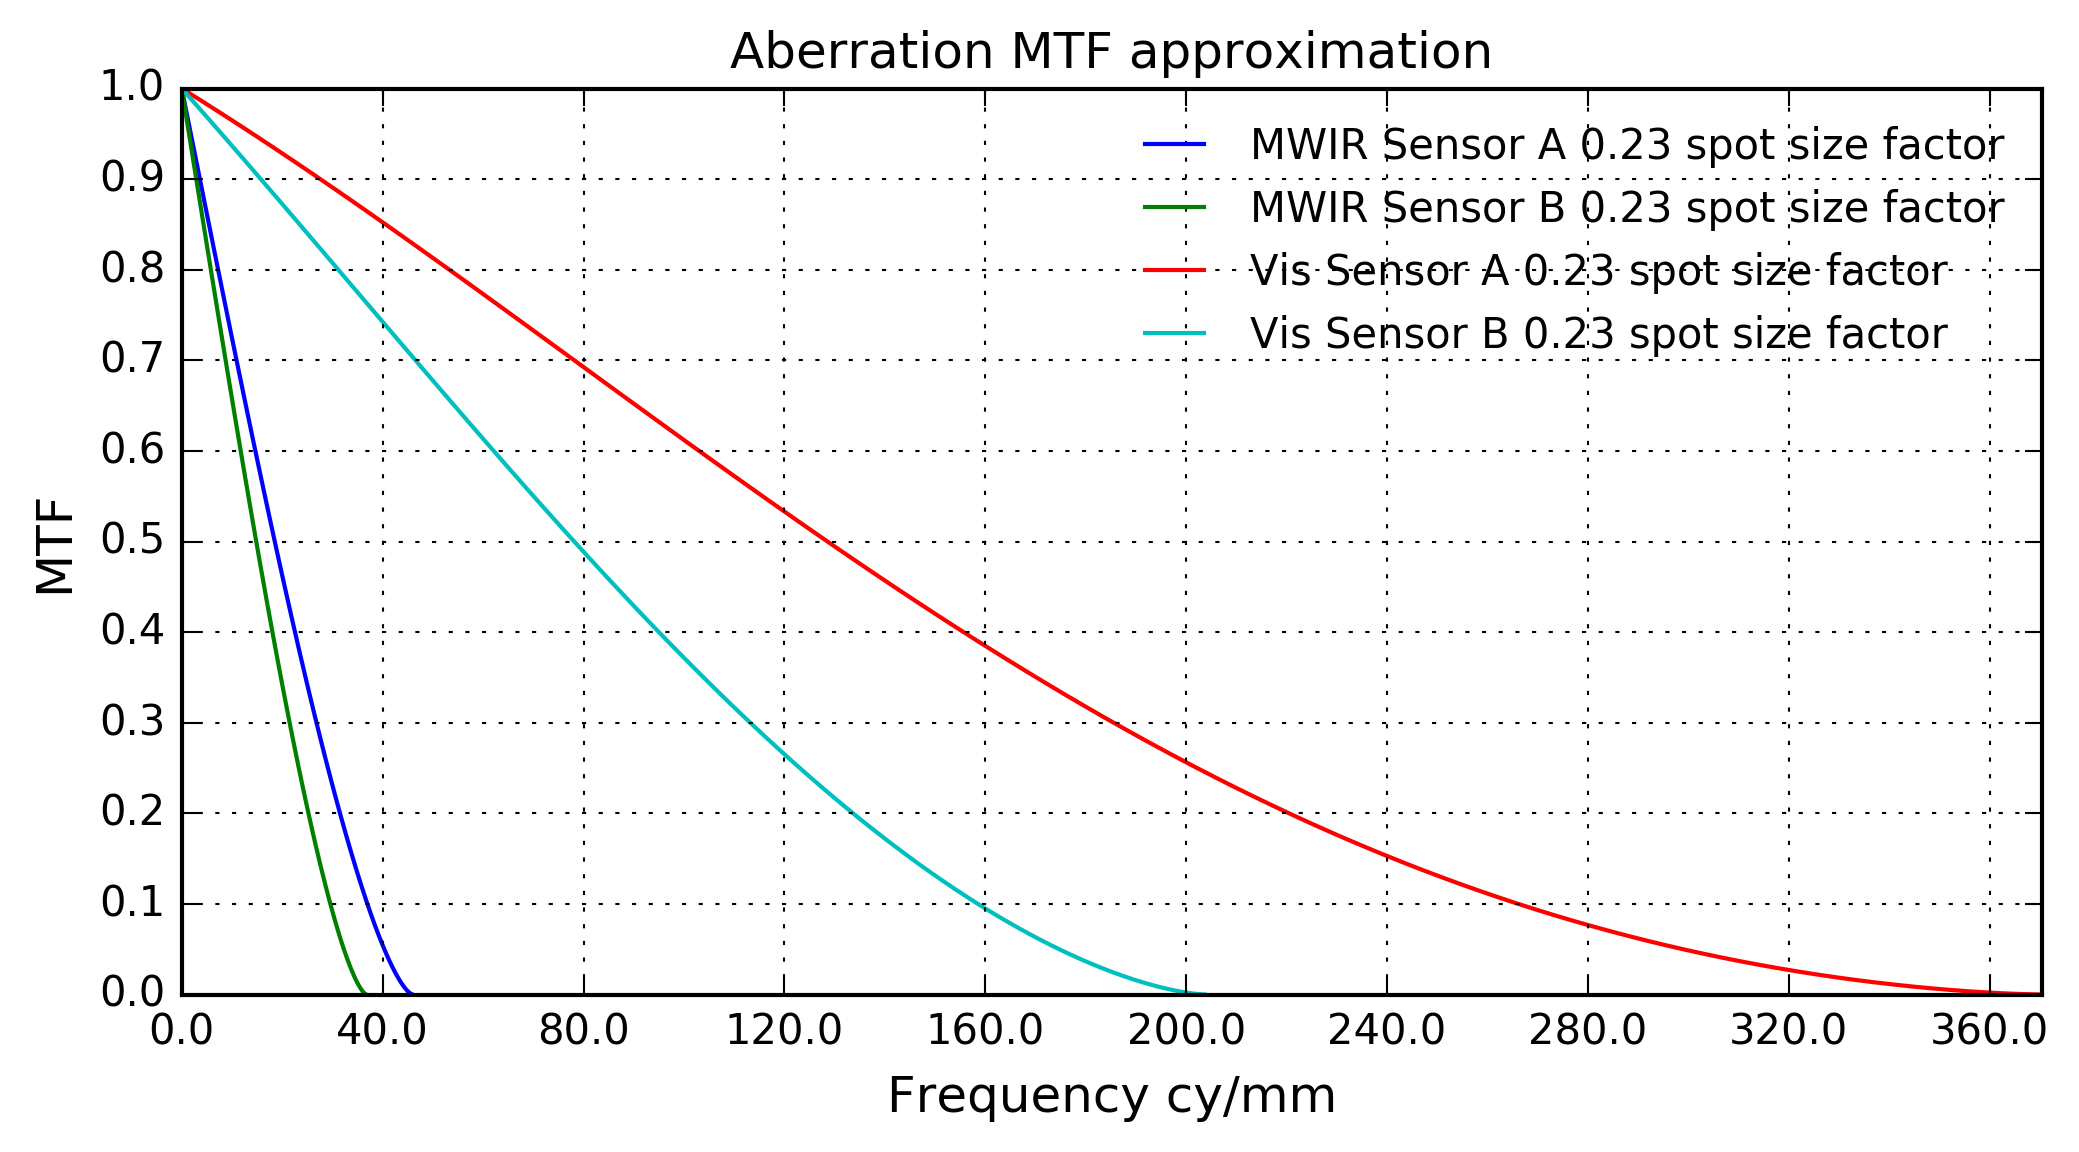

In [7]:
# to plot the aberration MTF as function of spot size factor
p = ryplot.Plotter (1 ,1 ,1 , figsize =(8,4) )
if 'MTF aberration' not in dfS.index.values:
    dfS = dfS.append(pd.DataFrame(index=['MTF aberration']))

ffreqmax = np.max(dfS.loc['SpatFreqMax cy/m'])
for colname in dfS.columns.values:
    ffreq = dfS.loc['SpatFreq cy/m'][colname]
    sratio= dfS.loc['Aberration size factor'][colname]
    dfS.loc['MTF aberration'][colname] = MTFcirc(ffreq) * MTFaberation(ffreq, sratio, ffreqmax)
    
    p.plot(1, ffreq/1000.,dfS.loc['MTF aberration'][colname], 
           r'Aberration MTF approximation','Frequency cy/mm','MTF',
           label =[r'{} {} spot size factor'.format(colname,sratio)], 
           pltaxis =[0,ffreqmax/1000.,-0,1]) ;   

### Diffraction MTF

The optical transfer function is the Fourier transform of the point spread function, and the point spread function is the square absolute of the inverse Fourier transformed pupil function. The optical transfer function can also be calculated directly from the pupil function. From the convolution theorem it can be seen that the optical transfer function is  the auto-correlation of the pupil function <https://en.wikipedia.org/wiki/Optical_transfer_function>.  If an image of the pupil function is known the  diffraction MTF of the pupil can be calculated numerically.

The fractional clear aperture and area of the sensor are calculated by simply counting the number of pixels in the clear aperture (accounting for the fact that the aperture is circular, not square as is the image).  The MTF is calculated using the SciPy two-dimensional correlation function `signal.correlate2d`.

In this calculation the MTF for a clear aperture and centrally obscured aperture is calculated, both of which have closed form analytical equations. The advantage of calculating the MTF from the pupil function is that any shape aperture can be used; just create an image of the pupil. The calculation takes a long time to calculate for large images, so the image can be subsampled to the required degree of accuracy.

In the MTF calculations below the MTF of a round aperture is calculated in square image coordinates. When the frequency scale is calculated, the distance to the corner of the image determines the full scale frequency of the calculation.  This full scale frequency is an artifact of the calculation, and is not the aperture cutof frequency that has optical meaning.  The full scale frequency is given by 

\begin{equation}
\xi_\textrm{fs} = \frac{\sqrt{2} D}{\lambda f}
\end{equation}

where the $\sqrt{2}$ accounts for the distance to the corner (relative to the round aperture diameter), 
$D$ is the aperture diameter,
$\lambda$ is the wavelength, and 
$f$ is the distance to the screen (e.g., focal length).

Then the optical cutof frequency or critical frequency is given by

\begin{equation}
\xi_0 = \xi_\textrm{fs}/\sqrt{2} = \frac{ D}{\lambda f}
\end{equation}

The calculation below was performed for a screen/focal distance of 1 m.  This essentially means that the units of $\xi_0$ is cycles/rad.  The spatial frequency in cycles/m for any focal length $f$ can then be found as 
$\xi_\textrm{cycles/m} = \xi_\textrm{cycles/rad}/f$



In [8]:
# to calculate the autocorrelation and clear area and write to file
# this function may take a long time to execute
def pupilautocor(PIK, dOptics, sampling = 5):

    fracclear = {}
    areasens = {}
    pupil = {}
    corrn = {}
    polar_corrn = {}
    polar_radius = {}
    meanmtf = {}
    
    for i,mtflabel in enumerate(dOptics.keys()):
        filename = dOptics[mtflabel]['Pupil']
        print(mtflabel,filename)

        #read the mask image
        pup = ndimage.imread(filename).astype(float)
        #make binary image
        pup[...,-1] = np.where(pup[...,-1]>0, 1.0, 0.0)
        #area-circle=pi*r^2, area-square=4*r^2, ratio=pi/4
        fracclear[mtflabel] = (4. / np.pi) * np.sum(pup[...,-1])/(pup[...,-1].shape[0]*pup[...,-1].shape[1])

        # slice, cut out one plane and exact size
        pupil[mtflabel] = pup[::sampling,0:pup.shape[0]:sampling,3] 
        #http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.correlate2d.html
        corr = signal.correlate2d(pupil[mtflabel], pupil[mtflabel], boundary='fill', mode='full')
        corrn[mtflabel] = corr / np.max(corr)

        #do for autocorrelation
        polar_c, _, _ = pim.reprojectImageIntoPolar(corrn[mtflabel].reshape(corrn[mtflabel].shape[0],corrn[mtflabel].shape[1],1), None, False,cval=0.)
        polar_c = polar_c[:,:,0]
        polar_corrn[mtflabel] = polar_c
        #do for radius
        polar_c, _, _ = pim.reprojectImageIntoPolar(pupil[mtflabel].reshape(pupil[mtflabel].shape[0],pupil[mtflabel].shape[1],1), None, False,cval=0.)
        polar_c = np.flipud(polar_c[:,:,0])
        polar_radius[mtflabel] = polar_c

        meanmtf[mtflabel] = polar_corrn[mtflabel].mean(axis=1)
        
    data = (pupil, corrn, pupfn, mtflabels, fracclear, areasens, polar_corrn, polar_radius, meanmtf)
    with open(PIK, "wb") as f:
        pickle.dump(data, f)
                

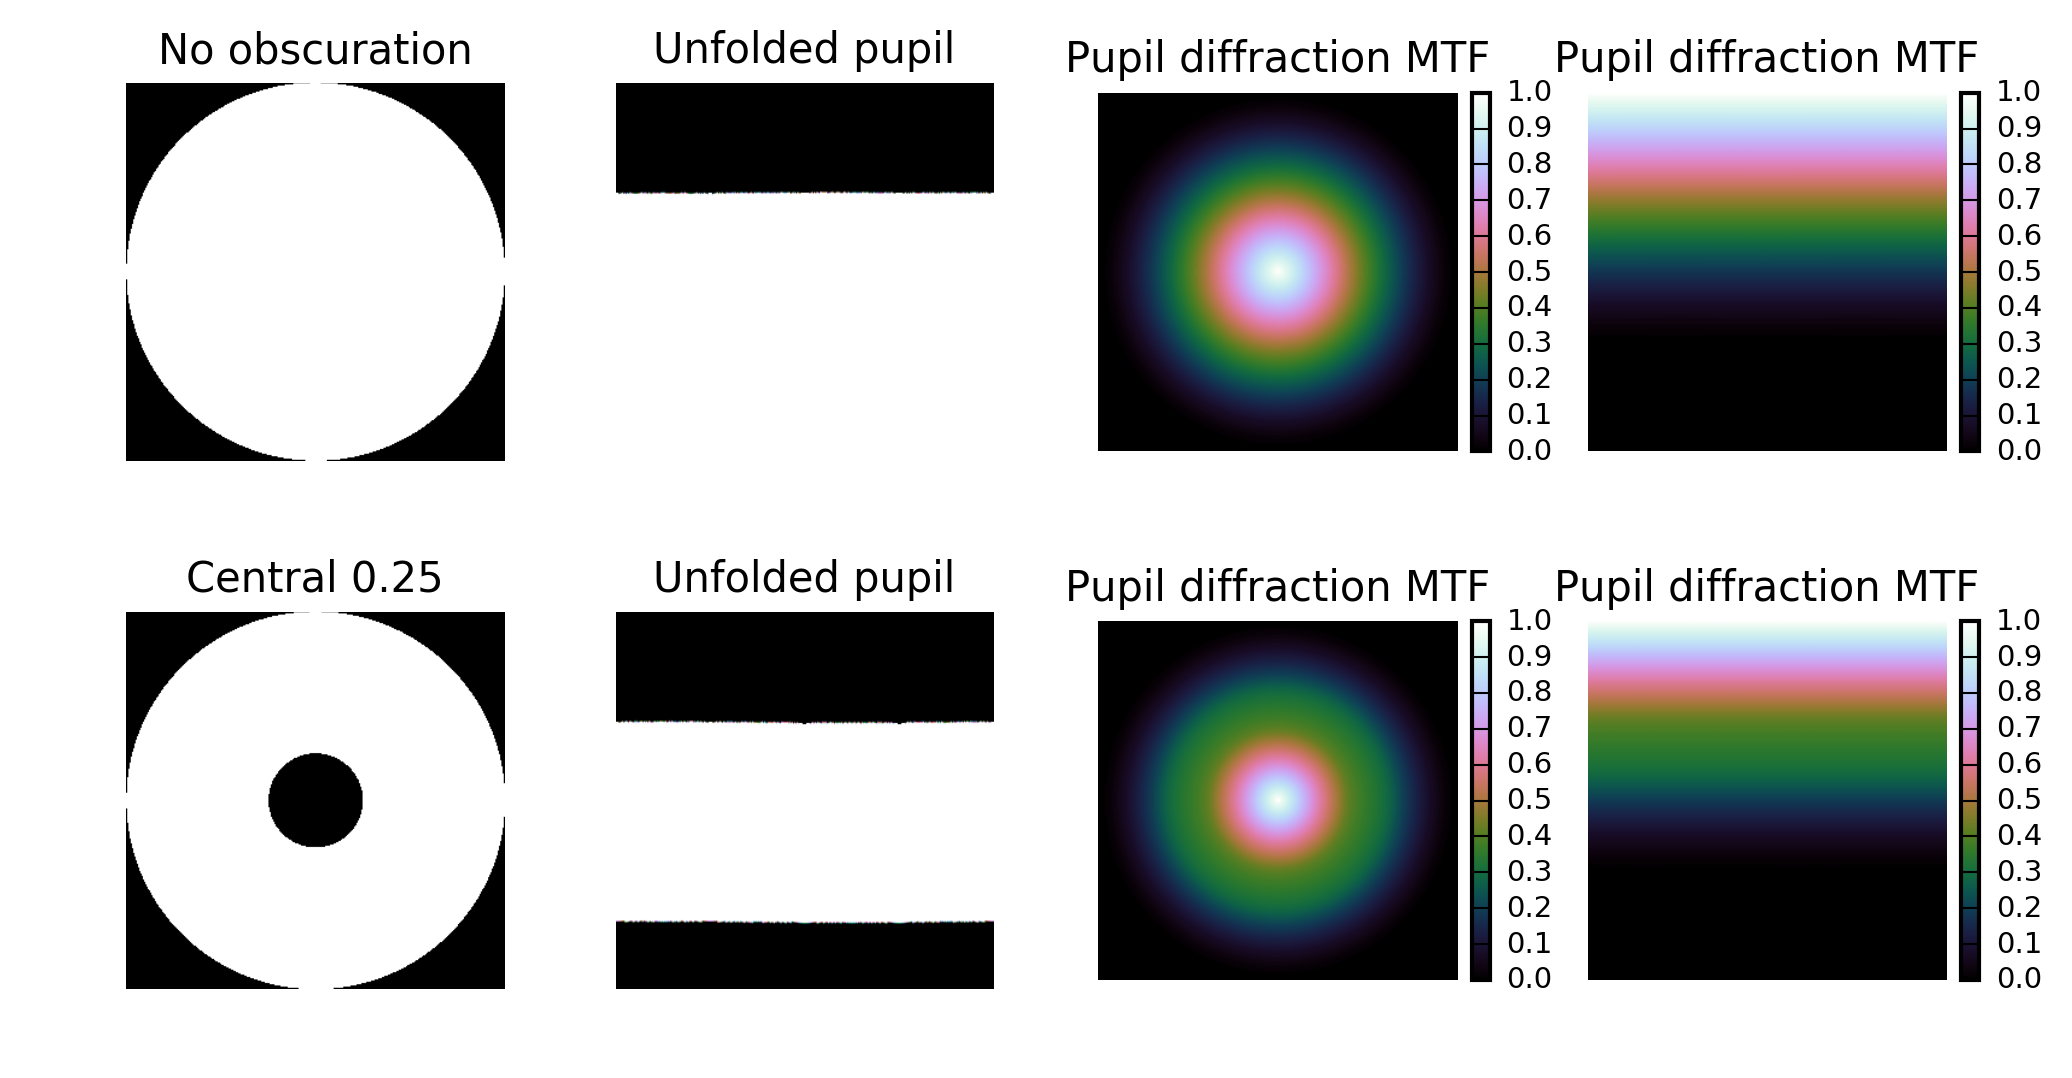

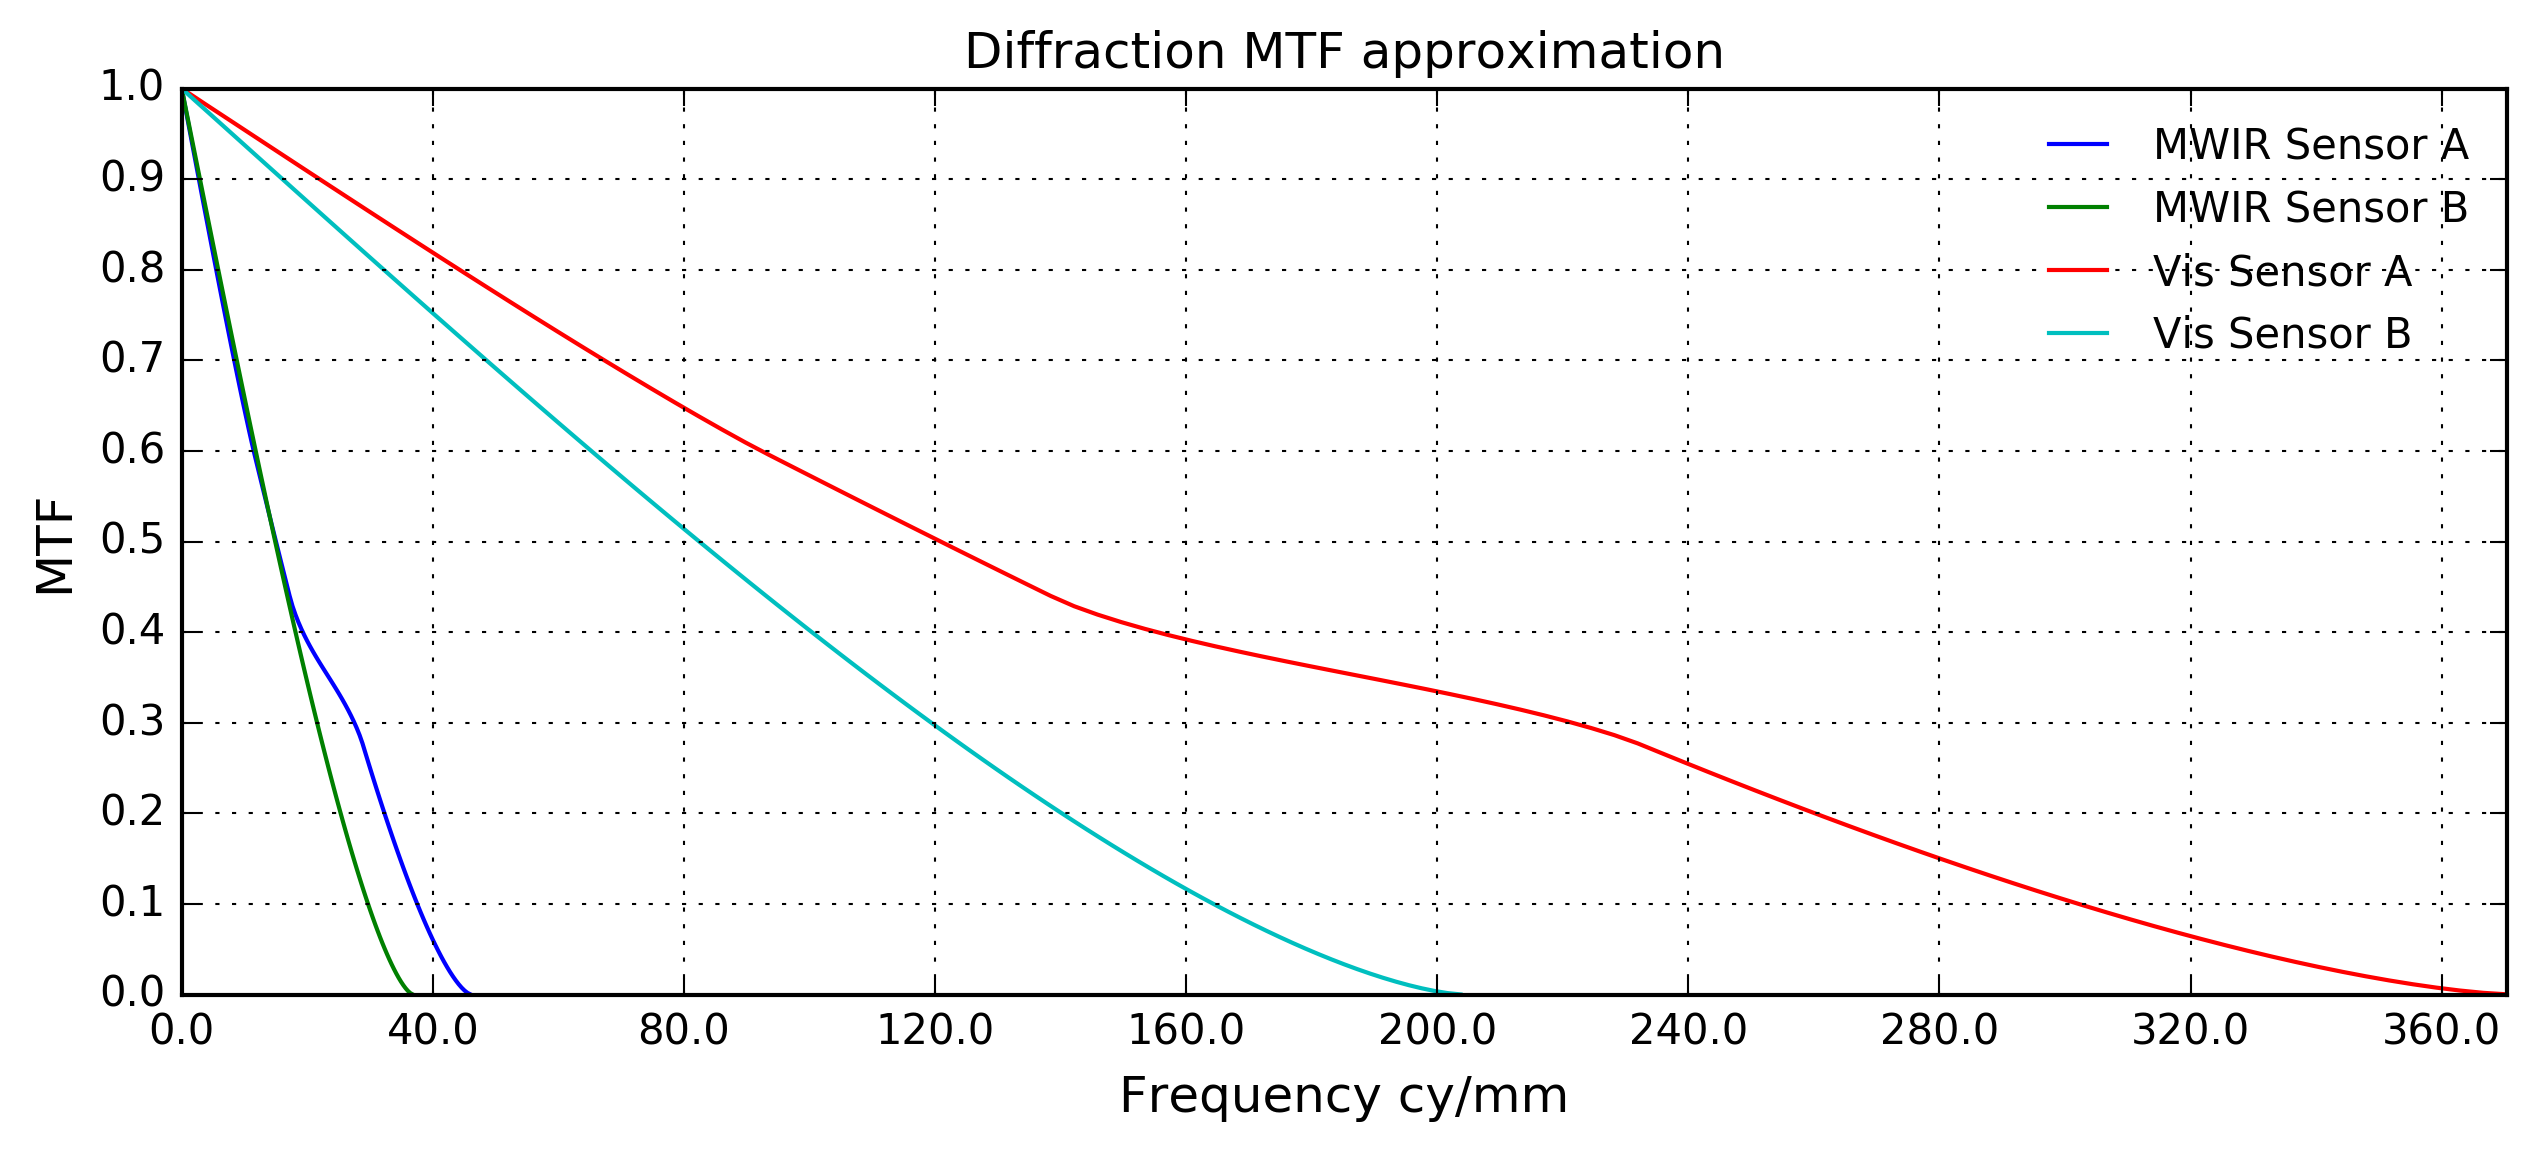

In [9]:
# to calculate the mtf

#NOTE!!!!!!!!
# The reprojectImageIntoPolar function maps radial to cartesian coords. 
# The radial image is however presented in a cartesian grid, the corners have no meaning.
# The radial coordinates are mapped to the radius, not the corners.
# This means that in order to map corners, the frequency is scaled with sqrt(2), 
# The corners are filled with the value specified in cval, which must be zero

mtfpclfilename = 'ApertureMTF.pcl'

freqfsm = {}
rho = {}
fcrit = {}

#calculate if not already existing
if not os.path.exists(mtfpclfilename):
    pupilautocor(mtfpclfilename, dOptics, sampling = 5)
    
#load the correlation data from the pickle file
with open(mtfpclfilename, "rb") as f:
    (pupil, corrn, pupfn, mtflabels, fracclear, areasens, polar_corrn, polar_radius, meanmtf) = pickle.load(f)
    
    I = ryplot.Plotter(1,2,4,'', figsize=(8,4));

    for i,mtflabel in enumerate(dOptics.keys()):
        I.showImage(4*i+1, pupil[mtflabel], ptitle=mtflabel, cmap=ryplot.cubehelixcmap(), titlefsize=10,  
                    cbarshow=False);
        I.showImage(4*i+2, polar_radius[mtflabel], ptitle='Unfolded pupil', cmap=ryplot.cubehelixcmap(), titlefsize=10,  
                    cbarshow=False);
        I.showImage(4*i+3, corrn[mtflabel], ptitle='Pupil diffraction MTF', cmap=ryplot.cubehelixcmap(), titlefsize=10,  
                    cbarshow=True, cbarorientation = 'vertical', cbarfontsize = 7);
        I.showImage(4*i+4, polar_corrn[mtflabel], ptitle='Pupil diffraction MTF', cmap=ryplot.cubehelixcmap(), titlefsize=10,  
                    cbarshow=True, cbarorientation = 'vertical', cbarfontsize = 7);
    

p = ryplot.Plotter(2,1,1,'', figsize=(10,4));
if 'MTF diffraction' not in dfS.index.values:
    dfS = dfS.append(pd.DataFrame(index=['MTF diffraction']))
ffreqmax = np.max(dfS.loc['SpatFreqMax cy/m'])
for colname in dfS.columns.values:
    freqfsm = np.sqrt(2.) * dfS.loc['SpatFreqMax cy/m'][colname]
    mtflabel = dfS.loc['MTF label'][colname]
    rho = np.linspace(0,freqfsm,polar_corrn[mtflabel].shape[0]) 
    ffreq = dfS.loc['SpatFreq cy/m'][colname]
    dfS.loc['MTF diffraction'][colname] = np.interp(ffreq, rho,  meanmtf[mtflabel])
    p.plot(1, ffreq/1000.,dfS.loc['MTF diffraction'][colname], 
           r'Diffraction MTF approximation','Frequency cy/mm','MTF',
           label =[r'{}'.format(colname)],pltaxis =[0,ffreqmax/1000.,-0,1]) ;   


### Line of sight movement MTF

Line of sight movement has two effects: (1) linear motion smear of the image during integration time, and (2) random movement blur during integration time.  The two degradation mechanisms have to different effect in the image.

Image degradation attributable to linear smear is modelled as a `sinc` function

\begin{equation}
MTF_{\textrm{smear}} = \textrm{sinc}\left( \pi\xi \dot{\theta} t_i \right)
\end{equation}

where 
$\xi$ is spatial frequency in cy/rad,
$\dot{\theta}$ is linear motion in rad/s, and 
$t_i$ is integration time in s

The units of the argument are 
\begin{equation}
\left[\frac{\textrm{rad}}{\textrm{cy}}\right]
\left[\frac{\textrm{cy}}{\textrm{rad}}\right]
\left[\frac{\textrm{rad}}{\textrm{s}}\right]
\left[\frac{\textrm{s}}{\textrm{1}}\right] \rightarrow \textrm{rad}
\end{equation}

The [G] model does not account for linear smear movement. Experiments have shown that smear results in more degradation than does random noise blur, so perhaps it should be included in the calculation.


Random noise blur is calculated as the 1-$\sigma$ residual random movement of the projected pixel direction after linear smear is removed.

The blur MTF is given by 

\begin{equation}
MTF_{\textrm{blur}} = \exp\left[-2(\pi \sigma_b \xi)^2\right]
\end{equation}
where
where 
$\xi$ is spatial frequency in cy/rad, and
$\sigma_b$ is the 1-$\sigma$ jitter during integration time in rad.


In [10]:
# to calculate smear MTF
def MTFsmear(freq, smearRate, inttime):
    # freq in cy/rad
    # smearRate in rad/s
    # inttime in s
    return np.sinc(freq * smearRate * inttime)

In [11]:
# to calculate blur MTF
def MTFblur(freq, rmsblur):
    # freq in cy/rad
    # rmsblur in rad
    return np.exp(-2 * (np.pi * freq  *  rmsblur) ** 2)

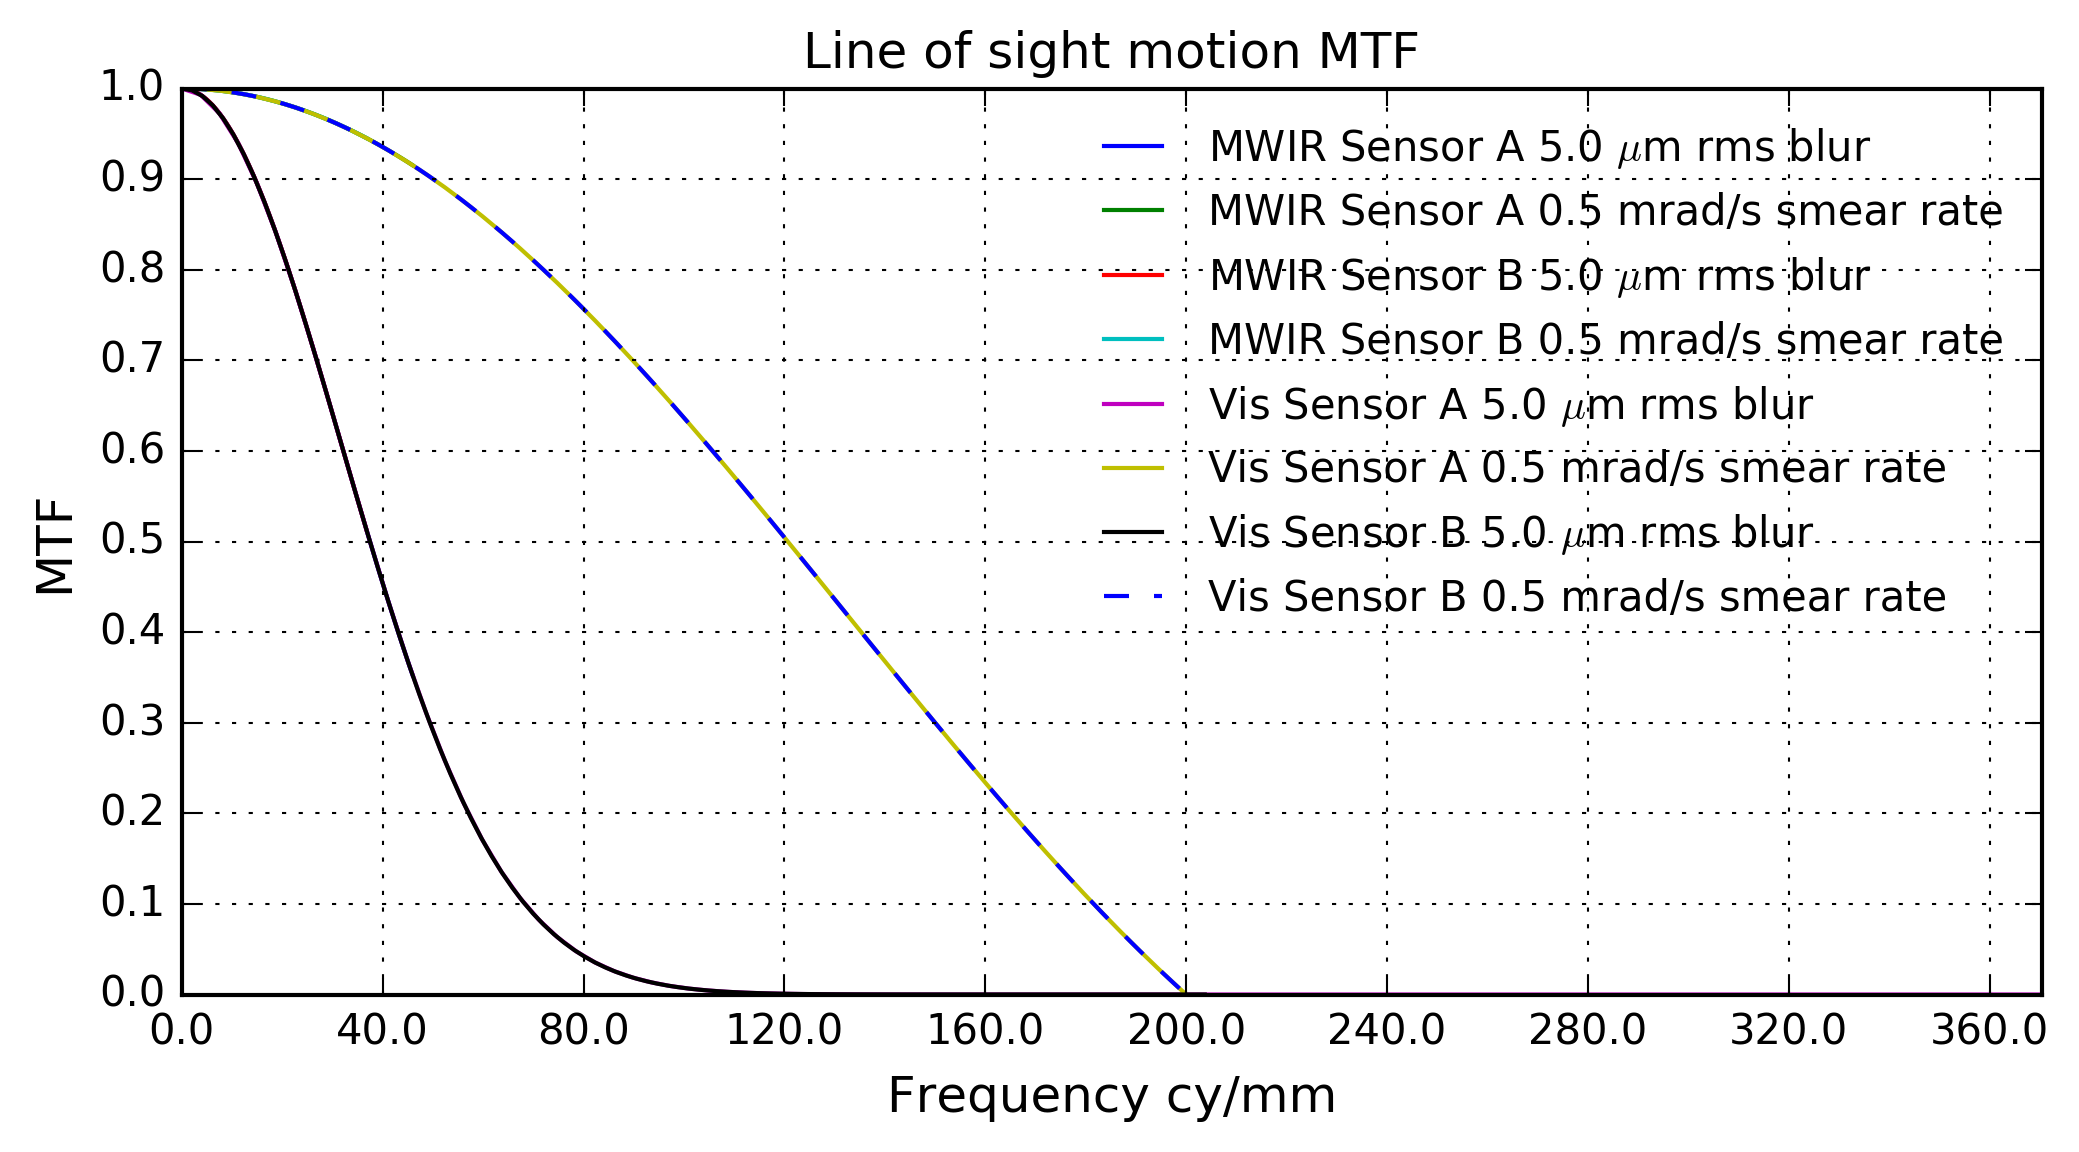

In [12]:
# to plot the smear and blus MTF as function of linear motion and blur.
p = ryplot.Plotter (1 ,1 ,1 , figsize =(8 ,4) )

if 'MTF smear motion' not in dfS.index.values:
    dfS = dfS.append(pd.DataFrame(index=['MTF smear motion']))
if 'MTF blur motion' not in dfS.index.values:
    dfS = dfS.append(pd.DataFrame(index=['MTF blur motion']))
ffreqmax = np.max(dfS.loc['SpatFreqMax cy/m'])
for colname in dfS.columns.values:
    ffreq = dfS.loc['SpatFreq cy/m'][colname]
    rmsblur= dfS.loc['RMS jitter rad'][colname]
    smearRate= dfS.loc['Linear smear rad/s'][colname]
    dfS.loc['MTF smear motion'][colname] = MTFsmear(ffreq, smearRate, inttime)
    dfS.loc['MTF blur motion'][colname] = MTFblur(ffreq, rmsblur)
    p.plot(1, ffreq/1000., dfS.loc['MTF blur motion'][colname],r'Line of sight motion MTF',
     'Frequency cy/mm','MTF',label=[r'{} {} $\mu$m rms blur'.format(colname,rmsblur*1e6)]);
    inttime = 0.01
    p.plot(1, ffreq/1000., dfS.loc['MTF smear motion'][colname],r'Line of sight motion MTF',
     'Frequency cy/mm','MTF',label=[r'{} {} mrad/s smear rate'.format(colname,smearRate*1e3)],
          pltaxis =[0,ffreqmax/1000.,-0,1]);
    

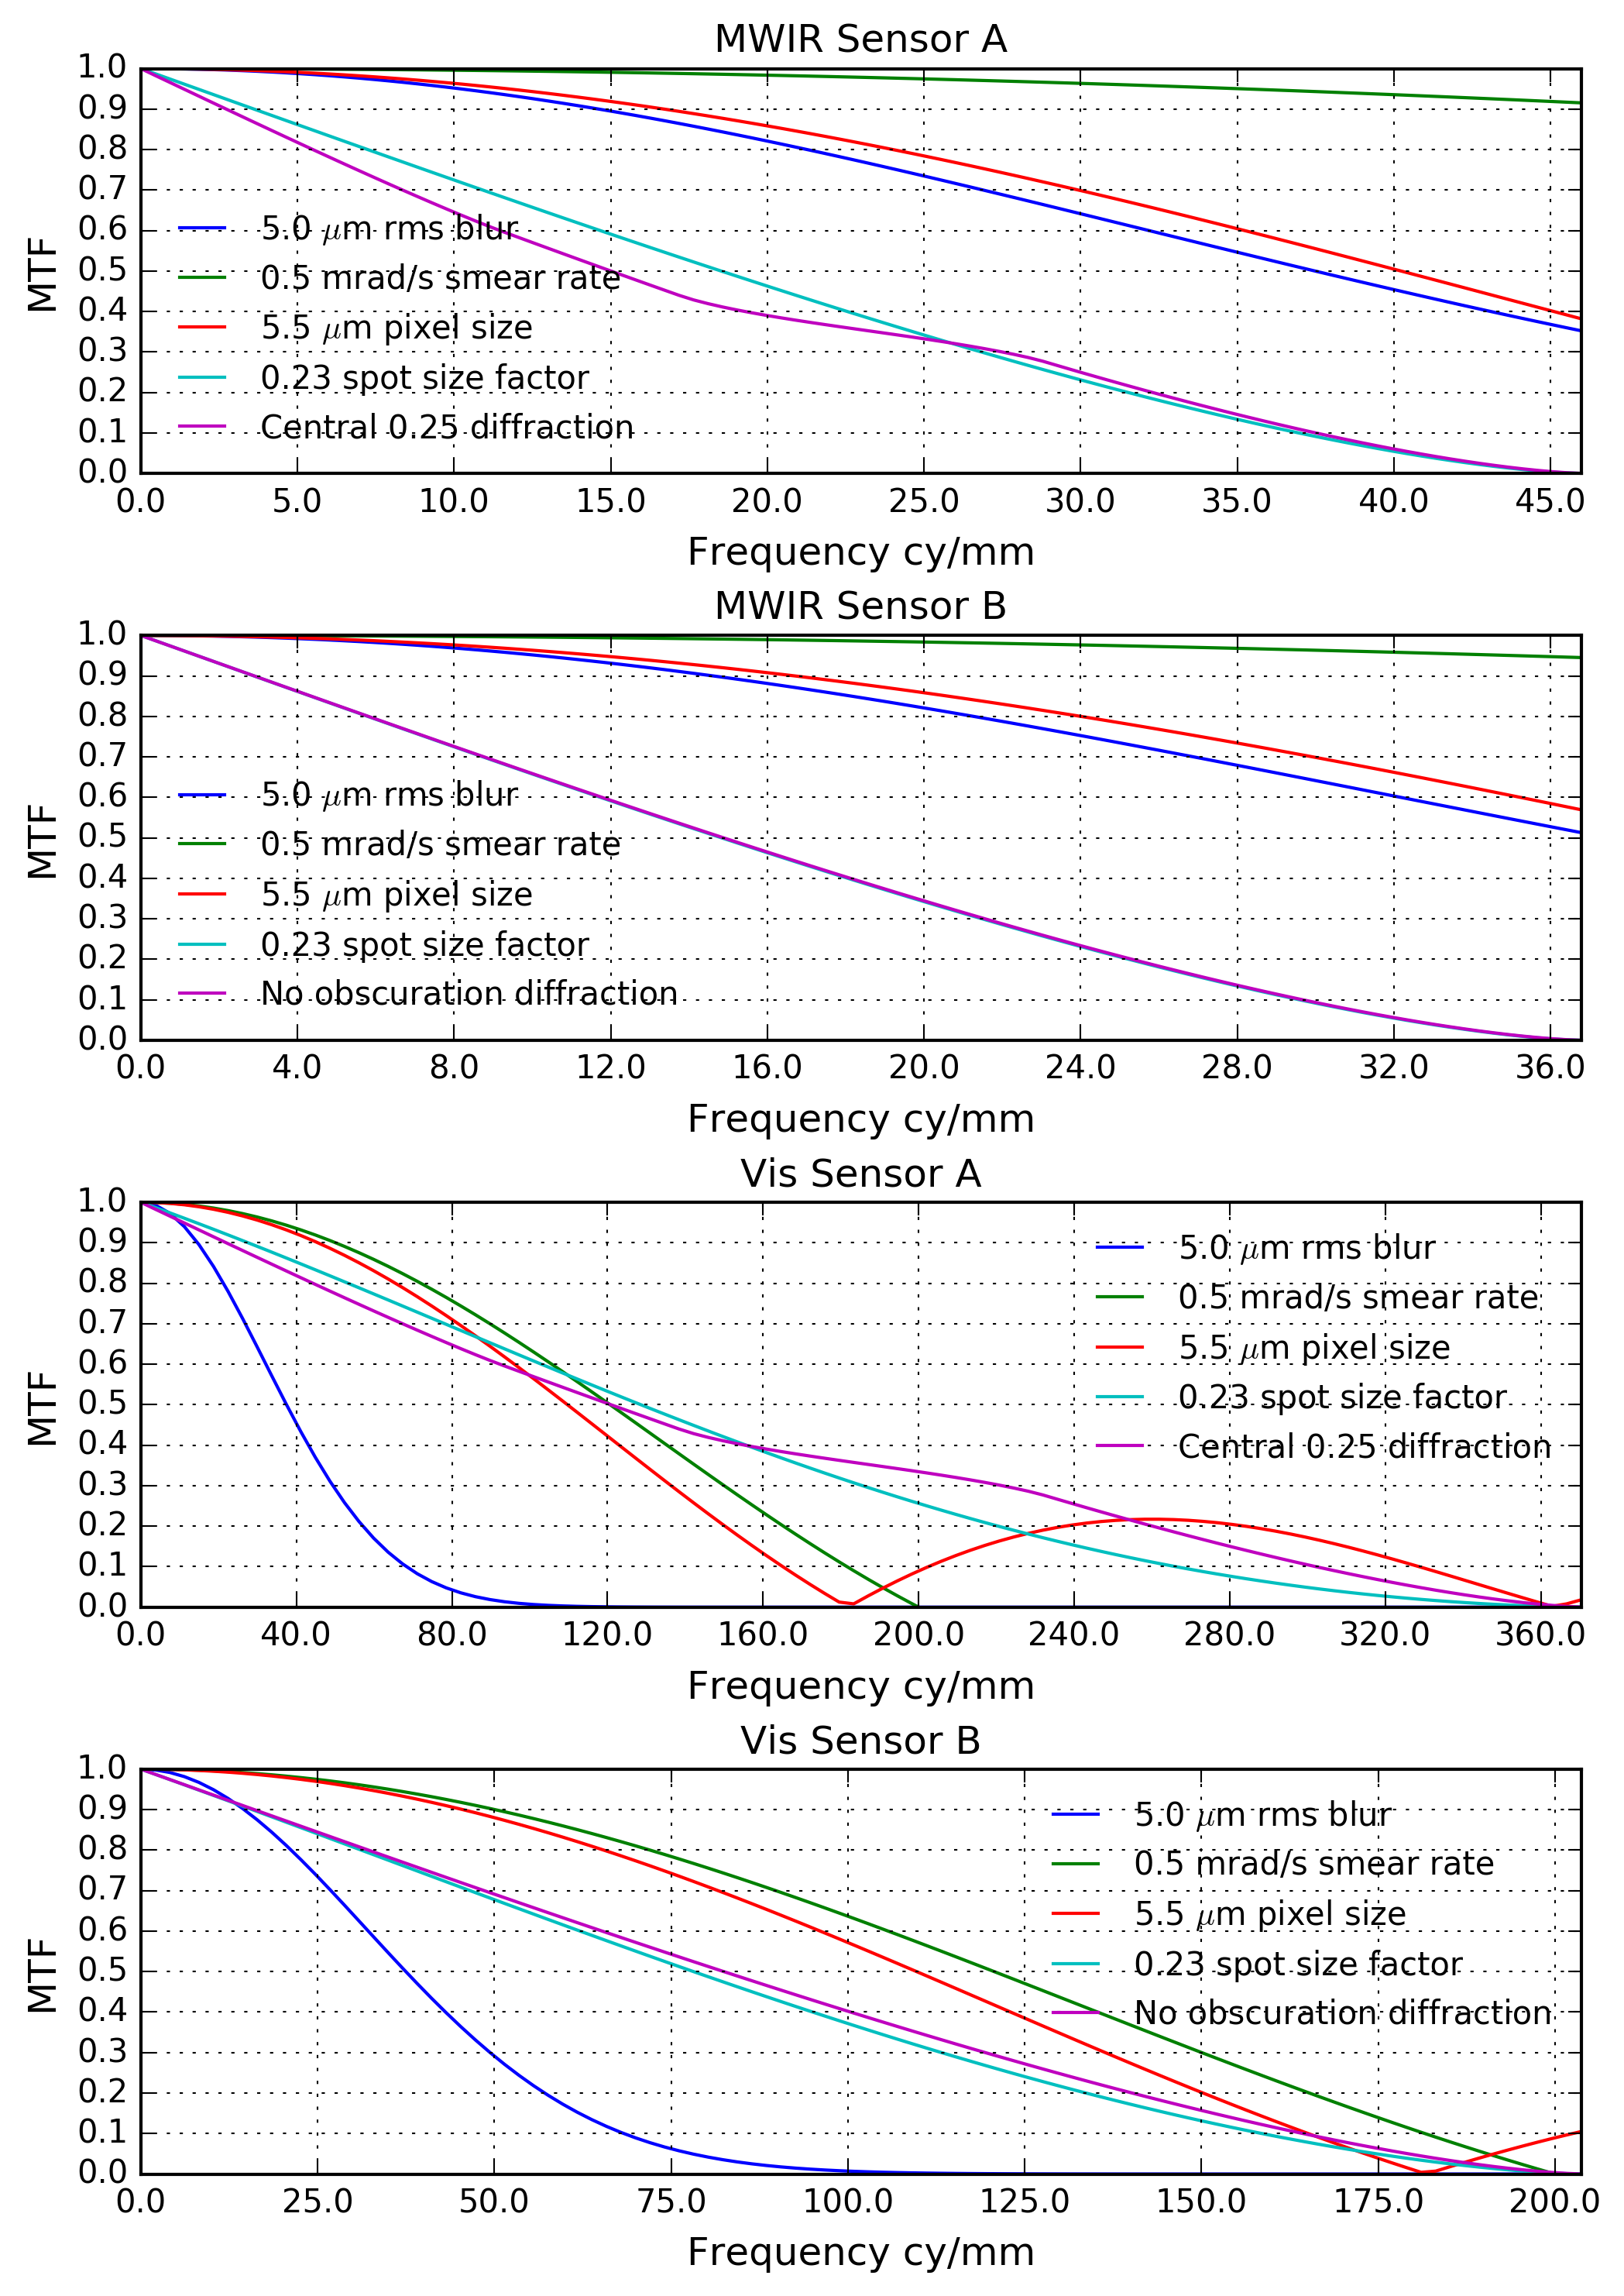

In [16]:
# to plot the MTF components per sensor
p = ryplot.Plotter (1 ,4 ,1 , figsize =(8 ,12) )

for i,colname in enumerate(dfS.columns.values):
    
    ffreq = dfS.loc['SpatFreq cy/m'][colname]
    rmsblur = dfS.loc['RMS jitter rad'][colname]
    smearRate = dfS.loc['Linear smear rad/s'][colname]
    ffreqmax = dfS.loc['SpatFreqMax cy/m'][colname]
    obscuration = dfS.loc['MTF label'][colname]
    
    p.resetPlotCol()
    
    p.plot(1+i, ffreq/1000., dfS.loc['MTF blur motion'][colname],
           r'{}'.format(colname),'Frequency cy/mm','MTF',
           label=[r'{} $\mu$m rms blur'.format(rmsblur*1e6)]);
    
    p.plot(1+i, ffreq/1000., dfS.loc['MTF smear motion'][colname],
           r'{}'.format(colname),'Frequency cy/mm','MTF',
           label=[r'{} mrad/s smear rate'.format(smearRate*1e3)]);

    p.plot(1+i, ffreq/1000., np.abs(dfS.loc['MTF detector'][colname]),
           r'{}'.format(colname),'Frequency cy/mm','MTF',
           label=[r'{} $\mu$m pixel size'.format(pixsize*1e6)]);
           
    p.plot(1+i, ffreq/1000.,dfS.loc['MTF aberration'][colname], 
           r'{}'.format(colname),'Frequency cy/mm','MTF',
           label =[r'{} spot size factor'.format(sratio)]) ;
    
    p.plot(1+i, ffreq/1000.,dfS.loc['MTF diffraction'][colname], 
           r'{}'.format(colname),'Frequency cy/mm','MTF',
           label =[r'{} diffraction'.format(obscuration)], 
           pltaxis =[0,ffreqmax/1000.,-0,1]) ;   
    

# Methodology

The text for this section is take with minor changes from [G].

In the optimization examples the optical aperture $D$ is considered the primary constraint, and thereafter
the following process is followed:

1. Using $D$, the pixel format and the pixel centre-to-centre dimension; the focal lengths $f$ are calculated for a
series of FOVs.
2. For each FOV the f-number is calculated and if it is less than a practical acceptable value, then the f-number is set to a chosen practical value.
3. For the input source/background temperature the stare time $t_\textrm{int}$ is adjusted until the detector well fill of 50% is achieved or until it reaches a limit determined by the frame time of the imaging sensor.
4. The sensor and/or system designer is then required to input how much pixel-to-pixel minimal processable modulation (MPM) is required to process individual pixels with the integrity and robustness applicable to the application e.g. 5% modulation is required for video auto-tracking.
5. All other sensor variables are manually input.
6. The model is run and the result is plotted against the FOV.
7. Finally the spatial frequency at which the required pixel-to-pixel MPM is achieved is calculated for each FOV and the model results from above is plotted against the spatial frequency at which the MPM is achieved.

In [14]:
# to load the sensor data from disk
# dfS = pd.read_excel('data/FOV-optimisation-parameters.xlsx', 'Sheet1', index_col=None, na_values=['NA'])
# dfS.set_index(keys='Sensor',inplace=True)
# print(dfS)

# Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [15]:
%load_ext version_information
%version_information numpy, scipy, matplotlib

Software versions
Python 2.7.11 64bit [MSC v.1500 64 bit (AMD64)]
IPython 4.0.3
OS Windows 7 6.1.7601 SP1
numpy 1.10.1
scipy 0.16.0
matplotlib 1.5.0
Tue Feb 09 09:39:34 2016 South Africa Standard Time